# Сегментация сетки

Добавлена зависимость от размера изображения

🔍 АНАЛИЗ ДЛЯ БОЛЬШИХ ИЗОБРАЖЕНИЙ
📏 Размер: 960 x 1280 пикселей
   Canny пороги: lower=110, upper=223
✅ Canny получен
   Размер ядра: 2

🔄 Анализ по регионам...
   Регион 1: найдено 69 линий
   Регион 2: найдено 83 линий
   Регион 3: найдено 15 линий
   Регион 4: найдено 27 линий

📊 Всего горизонтальных: 97
📊 Всего вертикальных: 97

📏 После кластеризации:
   Горизонтальных: 48
   Вертикальных: 48
   Гориз: медиана=18, стд=9.2
      ⚠️ Нерегулярно, используем средний шаг 18
   Вертик: медиана=18, стд=10.2
      ⚠️ Нерегулярно, используем средний шаг 18

🔨 ИТОГОВАЯ СЕТКА:
   Горизонтальных линий: 42
   Вертикальных линий: 40
   Ячеек: 41 x 39
   Размер ячейки: 18 x 18 пикселей


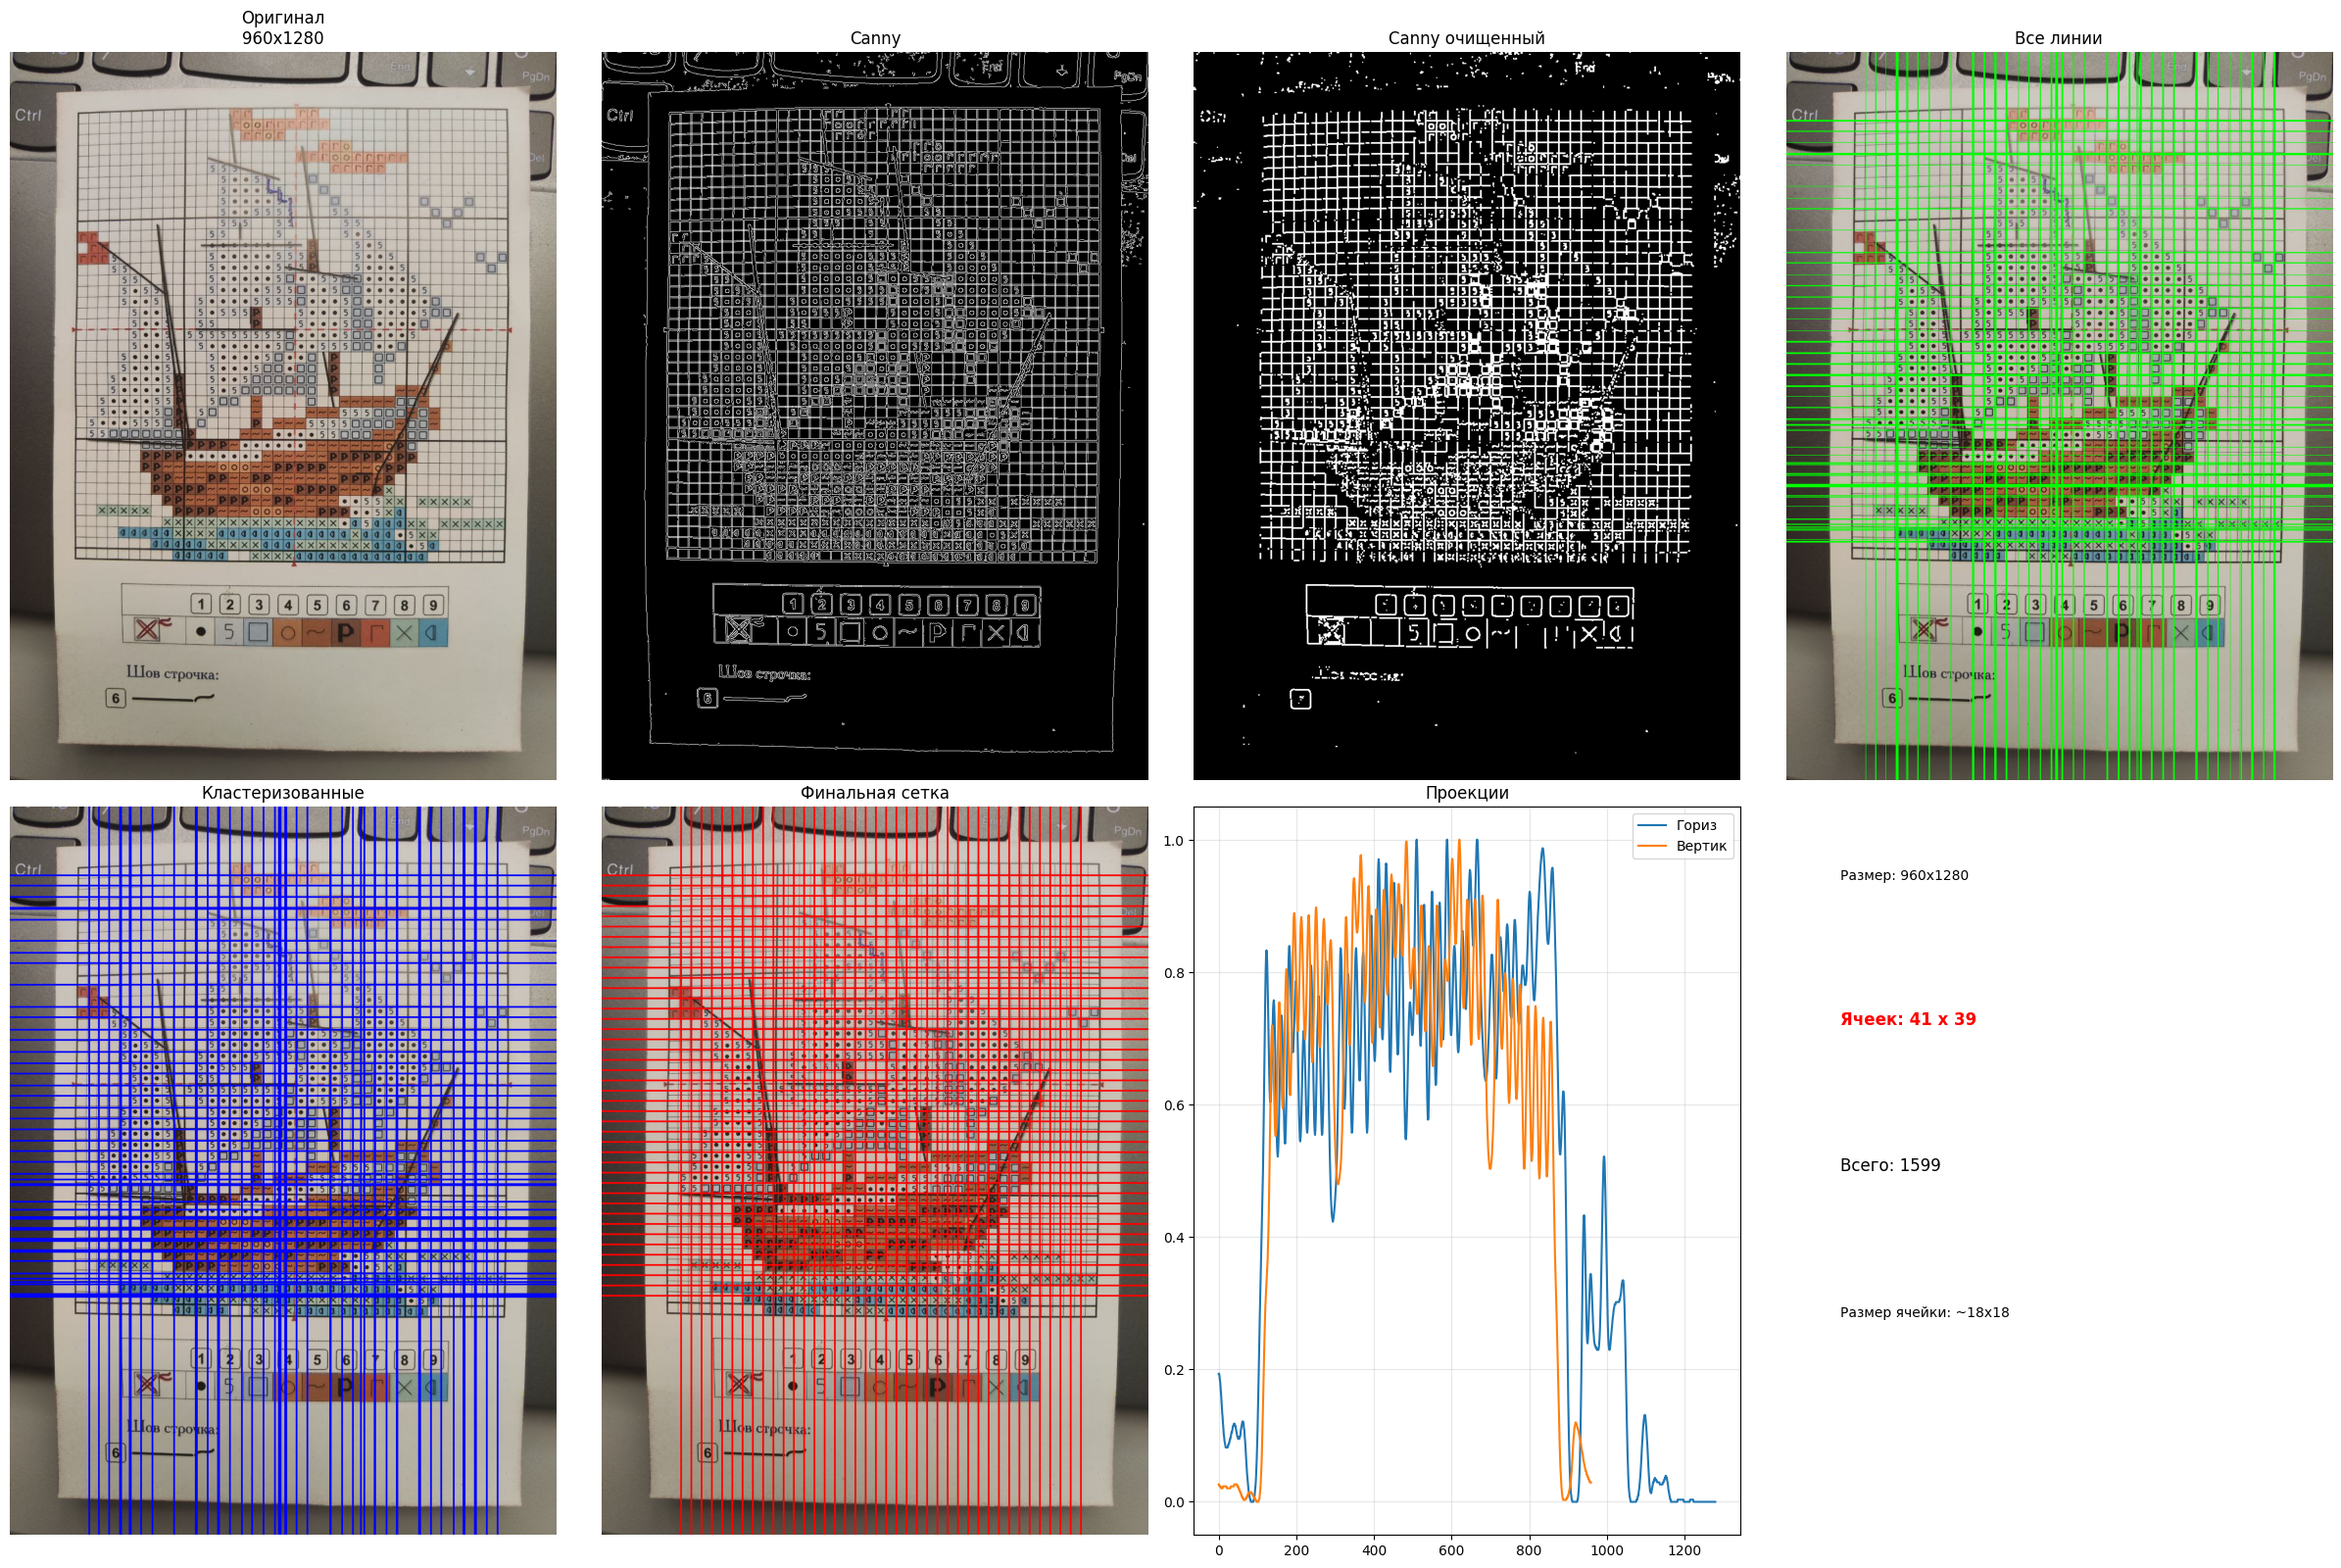


💾 Результат сохранен в high_res_grid.png

✅ УСПЕХ!
   Ячеек: 41 x 39


In [148]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import os

def analyze_grid_high_resolution(image_path, scale_factor=2.0):
    """
    Анализ сетки для больших изображений с адаптивными параметрами
    """
    print("="*60)
    print("🔍 АНАЛИЗ ДЛЯ БОЛЬШИХ ИЗОБРАЖЕНИЙ")
    print("="*60)
    
    # Загружаем
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Ошибка загрузки {image_path}")
        return None
    
    h, w = img.shape[:2]
    print(f"📏 Размер: {w} x {h} пикселей")
    
    # 1. РАБОТАЕМ В ОРИГИНАЛЬНОМ РАЗМЕРЕ (не уменьшаем!)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2. Адаптивные пороги CANNY (зависят от размера)
    # На больших изображениях линии ТОНЬШЕ, поэтому пороги должны быть меньше
    def adaptive_canny(img_gray):
        # Медиана для оценки шума
        median = np.median(img_gray)
        
        # Адаптивные пороги
        if max(img_gray.shape) > 2000:
            # Для очень больших - более чувствительные
            lower = int(max(0, 0.5 * median))
            upper = int(min(255, 1.2 * median))
        else:
            lower = int(max(0, 0.66 * median))
            upper = int(min(255, 1.33 * median))
        
        print(f"   Canny пороги: lower={lower}, upper={upper}")
        
        # Несколько проходов Canny с разными порогами
        edges_list = []
        
        # Основной проход
        edges = cv2.Canny(img_gray, lower, upper)
        edges_list.append(edges)
        
        # Более чувствительный проход
        edges2 = cv2.Canny(img_gray, lower//2, upper//2)
        edges_list.append(edges2)
        
        # Более строгий проход
        edges3 = cv2.Canny(img_gray, lower*2, upper*2)
        edges_list.append(edges3)
        
        # Объединяем все результаты
        combined = np.zeros_like(edges)
        for e in edges_list:
            combined = cv2.bitwise_or(combined, e)
        
        return combined
    
    canny = adaptive_canny(gray)
    print(f"✅ Canny получен")
    
    # 3. Адаптивная морфология (размер ядра зависит от размера изображения)
    kernel_size = max(2, int(min(h, w) / 500))
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    print(f"   Размер ядра: {kernel_size}")
    
    # Закрытие и открытие для улучшения линий
    canny_cleaned = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel)
    canny_cleaned = cv2.morphologyEx(canny_cleaned, cv2.MORPH_OPEN, kernel)
    
    # 4. РАБОТАЕМ ПО ЧАСТЯМ (разбиваем на регионы)
    print("\n🔄 Анализ по регионам...")
    
    # Разбиваем на 4 региона для более точного поиска
    h_center = h // 2
    w_center = w // 2
    
    regions = [
        (0, 0, w_center, h_center),           # верх-лево
        (w_center, 0, w, h_center),            # верх-право
        (0, h_center, w_center, h),            # низ-лево
        (w_center, h_center, w, h)             # низ-право
    ]
    
    all_horizontal = []
    all_vertical = []
    
    for idx, (x1, y1, x2, y2) in enumerate(regions):
        region = canny_cleaned[y1:y2, x1:x2]
        
        # Адаптивные параметры Hough для региона
        # если значение слишком маленькое - то получается большая чувствительность к линиям
        min_length_h = int((x2 - x1) * 0.3)  # 30% ширины региона
        min_length_v = int((y2 - y1) * 0.3)  # 30% высоты региона
        
        # lines = cv2.HoughLinesP(
        #     region,
        #     rho=1,
        #     theta=np.pi/180,
        #     threshold=80,
        #     minLineLength=min(min_length_h, min_length_v),
        #     maxLineGap=20
        # )

        # Определяем, горизонтальная это линия или вертикальная по соотношению сторон региона
        if (x2 - x1) > (y2 - y1):  # регион широкий - ищем горизонтальные линии
            lines = cv2.HoughLinesP(
                region,
                rho=1,
                theta=np.pi/180,
                threshold=20,  # меньший порог для горизонтальных
                minLineLength=int((x2 - x1) * 0.2),  # 60% ширины региона
                maxLineGap=30
            )
        else:  # регион высокий - ищем вертикальные линии
            lines = cv2.HoughLinesP(
                region,
                rho=1,
                theta=np.pi/180,
                threshold=80,
                minLineLength=int((y2 - y1) * 0.5),  # 50% высоты региона
                maxLineGap=20
            )
        
        if lines is not None:
            for line in lines:
                x1l, y1l, x2l, y2l = line[0]
                # Корректируем координаты
                x1l += x1
                x2l += x1
                y1l += y1
                y2l += y1
                
                length = np.sqrt((x2l - x1l)**2 + (y2l - y1l)**2)
                angle = abs(np.arctan2(y2l - y1l, x2l - x1l) * 180 / np.pi)
                
                # angle здесь - угол наклона 
                # Горизонтальные
                if angle < 20 or angle > 160:
                    if length > w * 0.05:  # 20% общей ширины
                        y_mid = (y1l + y2l) // 2
                        all_horizontal.append(y_mid)
                
                # Вертикальные
                elif angle > 70 and angle < 110:
                    if length > h * 0.2:  # 20% общей высоты
                        x_mid = (x1l + x2l) // 2
                        all_vertical.append(x_mid)
        
        print(f"   Регион {idx+1}: найдено {len(lines) if lines is not None else 0} линий")
    
    print(f"\n📊 Всего горизонтальных: {len(all_horizontal)}")
    print(f"📊 Всего вертикальных: {len(all_vertical)}")
    
    
    # КЛАСТЕРИЗАЦИЯ линий
    def cluster_lines(lines, image_size, cluster_divisor):
        if len(lines) < 2:
            return lines
        
        # Используем K-means для кластеризации
        lines = np.array(sorted(lines)).reshape(-1, 1)
        
        # Определяем количество кластеров
        # Этот параметр сильнее всего повлиял на то, что линии не сливались в одну, а определялись более корректно
        # cluster_divisor определяет количество кластеров
        n_clusters = max(1, len(lines) // cluster_divisor)
        
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=min(n_clusters, len(lines)), random_state=42)
        labels = kmeans.fit_predict(lines)
        
        # Берем центры кластеров
        clustered = []
        for i in range(max(labels) + 1):
            cluster_lines = lines[labels == i]
            if len(cluster_lines) > 0:
                clustered.append(int(np.median(cluster_lines)))
        
        return sorted(clustered)
    
    try:
        # Для горизонтальных - больше кластеров (чувствительнее)
        h_clustered = cluster_lines(all_horizontal, h, cluster_divisor=2)  # len(lines)//4
        # Для вертикальных - меньше кластеров (как было)
        v_clustered = cluster_lines(all_vertical, w, cluster_divisor=2)  # len(lines)//6
    except:
        # Fallback если нет sklearn
        h_clustered = sorted(set([int(round(l/30)*30) for l in all_horizontal]))
        v_clustered = sorted(set([int(round(l/30)*30) for l in all_vertical]))
    
    print(f"\n📏 После кластеризации:")
    print(f"   Горизонтальных: {len(h_clustered)}")
    print(f"   Вертикальных: {len(v_clustered)}")
    
    
    # 6. АНАЛИЗ РЕГУЛЯРНОСТИ
    def analyze_regularity(lines, is_horizontal, image_size):
        if len(lines) < 3:
            return lines, 50
        
        gaps = np.diff(lines)
        median_gap = int(np.median(gaps))
        std_gap = np.std(gaps)
        
        print(f"   {'Гориз' if is_horizontal else 'Вертик'}: медиана={median_gap}, стд={std_gap:.1f}")
        
        # Если разброс большой - используем медиану
        if std_gap > median_gap * 0.25:
            print(f"      ⚠️ Нерегулярно, используем средний шаг {median_gap}")
            
            # Строим регулярную сетку
            start = lines[0]
            end = lines[-1]
            regular = []
            pos = start
            while pos <= end:
                regular.append(int(pos))
                pos += median_gap
            
            return regular, median_gap
        
        return lines, median_gap
    
    h_final, h_step = analyze_regularity(h_clustered, True, h)
    v_final, v_step = analyze_regularity(v_clustered, False, w)

    
    
    print(f"\n🔨 ИТОГОВАЯ СЕТКА:")
    print(f"   Горизонтальных линий: {len(h_final)}")
    print(f"   Вертикальных линий: {len(v_final)}")
    print(f"   Ячеек: {len(h_final)-1} x {len(v_final)-1}")
    print(f"   Размер ячейки: {h_step} x {v_step} пикселей")
    
    # 7. ВИЗУАЛИЗАЦИЯ
    plt.figure(figsize=(24, 16))
    
    # Оригинал
    plt.subplot(2, 4, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Оригинал\n{w}x{h}')
    plt.axis('off')
    
    # Canny
    plt.subplot(2, 4, 2)
    plt.imshow(canny, cmap='gray')
    plt.title('Canny')
    plt.axis('off')
    
    # Canny очищенный
    plt.subplot(2, 4, 3)
    plt.imshow(canny_cleaned, cmap='gray')
    plt.title('Canny очищенный')
    plt.axis('off')
    
    # Все найденные линии
    img_all = img.copy()
    for y in all_horizontal[:100]:  # Ограничим для визуализации
        cv2.line(img_all, (0, y), (w, y), (0, 255, 0), 1)
    for x in all_vertical[:100]:
        cv2.line(img_all, (x, 0), (x, h), (0, 255, 0), 1)
    
    plt.subplot(2, 4, 4)
    plt.imshow(cv2.cvtColor(img_all, cv2.COLOR_BGR2RGB))
    plt.title('Все линии')
    plt.axis('off')
    
    # Кластеризованные
    img_clust = img.copy()
    for y in h_clustered:
        cv2.line(img_clust, (0, y), (w, y), (255, 0, 0), 2)
    for x in v_clustered:
        cv2.line(img_clust, (x, 0), (x, h), (255, 0, 0), 2)
    
    plt.subplot(2, 4, 5)
    plt.imshow(cv2.cvtColor(img_clust, cv2.COLOR_BGR2RGB))
    plt.title('Кластеризованные')
    plt.axis('off')
    
    # Финальная сетка
    # последнее значение - толщина
    img_final = img.copy()
    for y in h_final:
        cv2.line(img_final, (0, y), (w, y), (0, 0, 255), 2)
    for x in v_final:
        cv2.line(img_final, (x, 0), (x, h), (0, 0, 255), 2)
    
    plt.subplot(2, 4, 6)
    plt.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
    plt.title('Финальная сетка')
    plt.axis('off')
    
    # Проекции
    plt.subplot(2, 4, 7)
    h_proj = np.sum(canny_cleaned > 128, axis=1)
    v_proj = np.sum(canny_cleaned > 128, axis=0)
    h_proj = gaussian_filter1d(h_proj, sigma=5)
    v_proj = gaussian_filter1d(v_proj, sigma=5)
    plt.plot(h_proj / np.max(h_proj), label='Гориз')
    plt.plot(v_proj / np.max(v_proj), label='Вертик')
    plt.title('Проекции')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Инфо
    plt.subplot(2, 4, 8)
    plt.text(0.1, 0.9, f'Размер: {w}x{h}', fontsize=10)
    plt.text(0.1, 0.7, f'Ячеек: {len(h_final)-1} x {len(v_final)-1}', fontsize=12, color='red', weight='bold')
    plt.text(0.1, 0.5, f'Всего: {(len(h_final)-1)*(len(v_final)-1)}', fontsize=12)
    plt.text(0.1, 0.3, f'Размер ячейки: ~{h_step}x{v_step}', fontsize=10)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Сохраняем
    cv2.imwrite('high_res_grid.png', img_final)
    print("\n💾 Результат сохранен в high_res_grid.png")
    
    return {
        'h_lines': h_final,
        'v_lines': v_final,
        'grid_shape': (len(h_final)-1, len(v_final)-1),
        'cell_size': (h_step, v_step),
        'final_image': img_final
    }

if __name__ == "__main__":
    image_path = 'image.png'
    
    result = analyze_grid_high_resolution(image_path)
    
    if result:
        print("\n" + "="*60)
        print("✅ УСПЕХ!")
        print(f"   Ячеек: {result['grid_shape'][0]} x {result['grid_shape'][1]}")